In [1]:
!splitcode --version
!fasterq-dump --version

splitcode, version 0.30.0

fasterq-dump : 3.0.3 ( 3.0.2 )



In [17]:
outdir = "/mnt/data1/10XvParse/Analysis_2/"
fasta_folder = "FASTA/Raw/"
sra_folder = "SRA/"
tmp_folder = "tmp/"

proc_folder = "FASTA/Processed/"

proc_files = [outdir + proc_folder + "parse_1.fastq.gz", 
                outdir + proc_folder + "parse_2.fastq.gz"]
polyT_files = [outdir + proc_folder + "polyT_1.fastq.gz", 
                outdir + proc_folder + "polyT_2.fastq.gz"]
randO_files = [outdir + proc_folder + "randO_1.fastq.gz", 
                outdir + proc_folder + "randO_2.fastq.gz"]


In [3]:
file_names = []
srrs = []

with open("parse_extraction/parse_accession.txt") as access:
    n = 0
    i = 0
    for line in access:
        if(not line.startswith('SRR')):
           i = 0
           n = int(line)
        else:
            i += 1
            srr = line.strip()
            name = f"mini_{n}_{i}"
            srrs.append(srr)
            file_names.append(name)

In [2]:
for srr, name in zip(srrs, file_names):
    print(outdir+fasta_folder+name)
    !prefetch {srr} --max-size u -O {outdir+sra_folder}
    !fasterq-dump --outdir {outdir+fasta_folder} --temp {outdir+tmp_folder} \
        --outfile {name+".fastq"} --split-files --skip-technical \
        {outdir+sra_folder+srr+"/"+srr+".sra"} --threads 8
    !pigz {outdir+fasta_folder+name+"_1.fastq"} -p 8
    !pigz {outdir+fasta_folder+name+"_2.fastq"} -p 8

/mnt/data1/10XvParse/Analysis_2/FASTA/mini_2_2

2025-07-23T03:33:21 prefetch.3.0.3: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2025-07-23T03:33:21 prefetch.3.0.3: 1) Downloading 'SRR27585875'...
2025-07-23T03:33:21 prefetch.3.0.3: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2025-07-23T03:33:21 prefetch.3.0.3:  Downloading via HTTPS...
2025-07-23T03:44:40 prefetch.3.0.3:  HTTPS download succeed
2025-07-23T03:45:02 prefetch.3.0.3:  'SRR27585875' is valid
2025-07-23T03:45:02 prefetch.3.0.3: 1) 'SRR27585875' was downloaded successfully
2025-07-23T03:45:02 prefetch.3.0.3: 'SRR27585875' has 0 unresolved dependencies
spots read      : 123,620,258
reads read      : 247,240,516
reads written   : 247,240,516


In [4]:
batch_file = "parse_batch.txt"
with open(batch_file, "w") as batch:
    for file in file_names:
        fastq_files = [outdir + fasta_folder + file + "_1.fastq.gz", 
                   outdir + fasta_folder + file + "_2.fastq.gz"]
        batch.write(f"{file}\t{fastq_files[0]}\t{fastq_files[1]}\n")


In [6]:
mapping = "run_info/parse_mapping.txt"
outb = "run_info/parse_barcodes.fastq.gz"
!splitcode --remultiplex -c parse_extraction/config_correct.txt\
    --nFastqs=2 --gzip -o {proc_files[0]},{proc_files[1]} \
    --outb={outb} --mapping={mapping} {batch_file} -t 8

* Using a list of 384 tags (vector size: 384; map size: 8,858; num elements in map: 12,672)
* will process sample 1: /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_1_2.fastq.gz
* will process sample 2: /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_2_2.fastq.gz
* will process sample 3: /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_3_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_1_3_2.fastq.gz
* will process sample 4: /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_2_1_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_2_1_2.fastq.gz
* will process sample 5: /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_2_2_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Raw/mini_2_2_2.fastq.gz
* will process sample 6: /mnt/data1/10

In [28]:
distances = 1
locations = "1:78:86"
with open("parse_extraction/config_RT.txt", "w") as config:
    config.write("tags\tsubs\tdistances\tlocations\n")
    with open("parse_extraction/r1_R.txt") as randO:
        with open("parse_extraction/r1_T.txt") as polyT:
            for lineO, lineT in zip(randO,polyT):
                lineO = lineO.strip()
                lineT = lineT.strip()
                config.write(f"{lineO}\t{lineT}\t{distances}\t{locations}\n")

In [8]:
# Divide the reads into different wells

with open("parse_extraction/keep_wells.txt", "w") as keep, open("parse_extraction/config_wells.txt", "w") as config:
    n = 0
    with open("parse_extraction/r1_R.txt", "r") as R:
        keep.truncate()
        config.truncate()
        config.write("tags\tlocations\tdistances\n")

        for line in R:
            n += 1
            keep.write(line.strip() + "\t" + outdir + "FASTA/wells/randO_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

    n = 0
    with open("parse_extraction/r1_T.txt", "r") as T:
        for line in T:
            n += 1
            keep.write(line.strip() + "\t" + outdir +  "FASTA/wells/polyT_well_" + str(n) + "\n")
            config.write(line.strip() + "\t" + "1:78:86" + "\t\t" + "1" + "\n")

In [16]:
# Extract by well
!splitcode -c parse_extraction/config_wells.txt --gzip --keep-r1-r2 \
    --keep=parse_extraction/keep_wells.txt --nFastqs=2 --no-output \
    --no-outb {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 192 tags (vector size: 192; map size: 5,885; num elements in map: 6,336)
* will process sample 1: /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_2.fastq.gz
399M reads processed         
done 
* processed 401,402,818 reads


In [7]:
# Extract polyT reads
!splitcode -c parse_extraction/config_RT_polyT.txt --nFastqs=2 --gzip \
    --assign -o {polyT_files[0]},{polyT_files[1]} \
    --outb=run_info/polyT_barcodes.fastq.gz --mapping=run_info/polyT_mapping.txt --summary=run_info/polyT_summary.txt \
    {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 288 tags (vector size: 288; map size: 6,072; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_2.fastq.gz
400M reads processed (46.6% assigned)
done 
* processed 401,402,818 reads, 187,061,165 reads were assigned


In [6]:
# Extract randO reads
!splitcode -c parse_extraction/config_RT_randO.txt --nFastqs=2 --gzip \
    --assign -o {randO_files[0]},{randO_files[1]} \
    --outb=run_info/randO_barcodes.fastq.gz --mapping=run_info/randO_mapping.txt --summary=run_info/randO_summary.txt \
    {proc_files[0]} {proc_files[1]} -t 8

* Using a list of 288 tags (vector size: 288; map size: 6,079; num elements in map: 9,504)
* will process sample 1: /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_1.fastq.gz
                         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_2.fastq.gz
399M reads processed (53.4% assigned)
done 
* processed 401,402,818 reads, 214,341,653 reads were assigned


In [9]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref --overwrite -d mouse -i index.idx -g t2g.txt

[2025-07-24 15:09:33,389]    INFO [download] Downloading files for mouse (standard workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/mouse_index_standard.tar.xz to tmp/mouse_index_standard.tar.xz
100%|██████████████████████████████████████| 82.8M/82.8M [00:03<00:00, 24.7MB/s]
[2025-07-24 15:09:36,899]    INFO [download] Extracting files from tmp/mouse_index_standard.tar.xz


In [10]:
# Prepare batch file to pseudalign reads by well
rando_well = outdir + "FASTA/wells/randO_well_"
polyt_well = outdir + "FASTA/wells/polyT_well_"
with open("parse_extraction/batch_wells.txt", "w") as batch:
    batch.truncate()
    for n in range(1,97):
        batch.write("RandO_Well" + str(n) + "\t" + rando_well + str(n) + "_R1.fastq.gz\t" + rando_well + str(n) + "_R2.fastq.gz\n")
    for n in range(1,97):
        batch.write("PolyT_Well" + str(n) + "\t" + polyt_well + str(n) + "_R1.fastq.gz\t" + polyt_well + str(n) + "_R2.fastq.gz\n")

In [16]:
parse_out = outdir + "parse_out"
# Pseudoalign all parse reads
!kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {parse_out} {proc_files[0]} {proc_files[1]}

[2025-07-24 17:01:59,897]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/parse_out from
[2025-07-24 17:01:59,897]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_1.fastq.gz
[2025-07-24 17:01:59,897]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/parse_2.fastq.gz


[2025-07-24 17:43:05,863]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/parse_out/output.bus to /mnt/data1/10XvParse/Analysis_2/parse_out/tmp/output.s.bus
[2025-07-24 17:43:28,806]    INFO [count] On-list not provided
[2025-07-24 17:43:28,806]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_2/parse_out
[2025-07-24 17:43:28,807]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_2/parse_out/tmp/output.s.bus
[2025-07-24 17:43:33,852]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_2/parse_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_2/parse_out/tmp/output.s.c.bus with on-list /mnt/data1/10XvParse/Analysis_2/parse_out/splitseq_version2_whitelist.txt
[2025-07-24 17:43:47,174]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/parse_out/tmp/output.s.c.bus to /mnt/data1/10XvParse/Analysis_2/parse_out/output.unfiltered.bus
[2025-07-24 17:44:02,339]    INFO [count] Generatin

In [11]:
wells_out = outdir + "wells_out"
# Pseudoalign parse reads by well
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {wells_out} --batch-barcodes parse_extraction/batch_wells.txt

[2025-07-24 15:10:17,969]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/wells_out from
[2025-07-24 15:10:17,969]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/wells_out/tmp/tmpqtqdrmg9
[2025-07-24 15:51:14,033]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/wells_out/output.bus to /mnt/data1/10XvParse/Analysis_2/wells_out/tmp/output.s.bus
[2025-07-24 15:51:33,864]    INFO [count] On-list not provided
[2025-07-24 15:51:33,864]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_2/wells_out
[2025-07-24 15:51:33,865]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_2/wells_out/tmp/output.s.bus
[2025-07-24 15:51:38,072]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_2/wells_out/tmp/output.s.bus to /mnt/data1/10XvParse/Analysis_2/wells_out/tmp/output.s.c.bus with on-list /mnt/data1/10XvParse/Analysis_2/wells_out/splitseq_version2_whitelist

In [34]:
polyT_out = outdir + "polyT_out"
# Perform pseudoalignment of polyT reads
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x SPLIT-SEQ -o {polyT_out} {polyT_files[0]} {polyT_files[1]} 

[2025-07-24 17:54:13,887]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/polyT_out from
[2025-07-24 17:54:13,887]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/polyT_1.fastq.gz
[2025-07-24 17:54:13,887]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/polyT_2.fastq.gz
[2025-07-24 18:13:49,941]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/polyT_out/output.bus to /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus
[2025-07-24 18:13:58,855]    INFO [count] On-list not provided
[2025-07-24 18:13:58,855]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_2/polyT_out
[2025-07-24 18:13:58,855]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus
[2025-07-24 18:14:01,459]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_2/polyT_out/tmp/output.s.bus to /mnt/data1/10XvParse/

In [14]:
randO_out = outdir + "randO_out"
# Perform pseudoalignment of randO reads 
!kb count --overwrite --h5ad -r parse_extraction/replace.txt -i index.idx -g t2g.txt -x SPLIT-SEQ -o {randO_out} {randO_files[0]} {randO_files[1]}

[2025-07-24 15:57:52,291]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/randO_out from
[2025-07-24 15:57:52,291]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/randO_1.fastq.gz
[2025-07-24 15:57:52,291]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Processed/randO_2.fastq.gz
[2025-07-24 16:19:32,184]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/randO_out/output.bus to /mnt/data1/10XvParse/Analysis_2/randO_out/tmp/output.s.bus
[2025-07-24 16:19:41,298]    INFO [count] On-list not provided
[2025-07-24 16:19:41,298]    INFO [count] Copying pre-packaged SPLIT-SEQ on-list to /mnt/data1/10XvParse/Analysis_2/randO_out
[2025-07-24 16:19:41,299]    INFO [count] Inspecting BUS file /mnt/data1/10XvParse/Analysis_2/randO_out/tmp/output.s.bus
[2025-07-24 16:19:44,002]    INFO [count] Correcting BUS records in /mnt/data1/10XvParse/Analysis_2/randO_out/tmp/output.s.bus to /mnt/data1/10XvParse/

In [18]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server
from scipy.stats import pearsonr

# Preprocess

In [35]:
# Read in the data
wells_data = anndata.read_h5ad(outdir+'wells_out/counts_unfiltered/adata.h5ad')
polyT_data = anndata.read_h5ad(outdir+'polyT_out/counts_unfiltered/adata.h5ad')
randO_data = anndata.read_h5ad(outdir+'randO_out/counts_unfiltered_modified/adata.h5ad')
parse_data = anndata.read_h5ad(outdir+'parse_out/counts_unfiltered_modified/adata.h5ad')

In [36]:
# Add in metadata and begin initial processing
datasets = [wells_data, polyT_data, randO_data, parse_data]
data_names = ['wells', 'polyT', 'randO', 'parse']

for data, name in zip(datasets, data_names):
    data.var["gene_codes"] = data.var.index.tolist()

    gene_names = []

    with open(outdir+name + '_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
        for line in file:
            gene_names.append(line.strip())

    data.var_names = gene_names

    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

In [38]:
# Add polyT and randO read counts to parse data

parse_data.obs['polyT_reads'] = 0
parse_data.obs.loc[polyT_data.obs_names, 'polyT_reads'] = polyT_data.obs['n_counts']

parse_data.obs['randO_reads'] = 0
parse_data.obs.loc[randO_data.obs_names, 'randO_reads'] = randO_data.obs['n_counts']

In [41]:
## This is a bit strange. May want to figure out why this is
print(parse_data.obs[parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'] != parse_data.obs['n_counts']])

                          n_genes  n_counts  polyT_reads  randO_reads
barcode                                                              
AAACATCGAACGTGATATGCTGCT     2692    5715.0         3208         2508
AAACATCGAAGACGGAACTTAGCT      860    1347.0          610          738
AAACATCGAAGACGGACCAATTCT     1108    1682.0          664         1019
AAACATCGAAGGACACACTCGTAA     3371    7746.0         3525         4223
AAACATCGAATCCGTCACTCCTGC     5777   22508.0         7976        14539
...                           ...       ...          ...          ...
TTCACGCAGTGTTCTACATTTACA      910    1446.0          376         1071
TTCACGCATCCGTCTACCAATTCT     1720    2857.0         1223         1636
TTCACGCATGAAGAGAACTTAGCT     1972    3695.0         1861         1837
TTCACGCATGGCTTCACCAATTCT      490     603.0          302          302
TTCACGCATTCACGCAACTTAGCT      913    1372.0          609          764

[5550 rows x 4 columns]


# Parse Well Analysis

In [43]:
# Add well/read information (well number, whether polyT/randO) to wells_data
with open(outdir+'wells_out/matrix.sample.barcodes', 'r') as well_barcodes:
    well_barcodes = well_barcodes.read().splitlines()
randO_barcodes = well_barcodes[:96] # First 96 are randO reads
polyT_barcodes = well_barcodes[96:193] # Next 96 are polyT reads

wells_data.obs['well'] = -1

wells_data.obs['randO'] = False
for well, randO_barcode in enumerate(randO_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'randO'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(randO_barcode), 'well'] = well + 1

wells_data.obs['polyT'] = False
for well, polyT_barcode in enumerate(polyT_barcodes):
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'polyT'] = True
    wells_data.obs.loc[wells_data.obs.index.str.startswith(polyT_barcode), 'well'] = well + 1

In [44]:
# Calculates the Concordance Correlation Coefficient (CCC) between two array-like objects
def CCC(x, y):
    pearson_r = pearsonr(x,y).correlation
    return 2 * pearson_r * x.std() * y.std() / (x.std()**2 + y.std()**2 + (x.mean() - y.mean())**2)


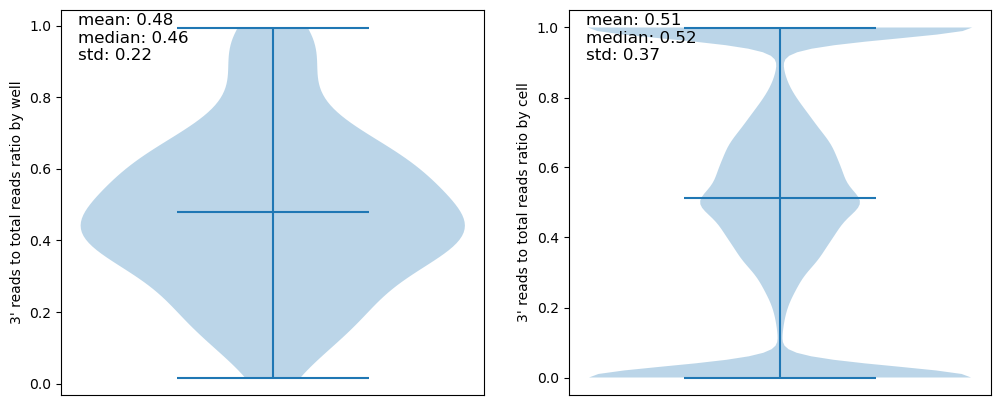

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

well_read_ratios = wells_data.obs[wells_data.obs['polyT']].groupby('well')['n_counts'].sum() / wells_data.obs.groupby('well')['n_counts'].sum()
well_read_ratios = well_read_ratios[well_read_ratios >= 0]  

ax[0].violinplot(well_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[0].set_xticks([])
ax[0].set_ylabel("3' reads to total reads ratio by well") 
string = "mean: " + str(round(np.mean(well_read_ratios),2)) + "\nmedian: " + str(round(np.median(well_read_ratios),2)) + "\nstd: " + str(round(np.std(well_read_ratios),2))
ax[0].text(0.04, 0.87, string, transform=ax[0].transAxes, fontsize=12)

cell_read_ratios = parse_data.obs['polyT_reads'] / (parse_data.obs['polyT_reads'] + parse_data.obs['randO_reads'])
cell_read_ratios = cell_read_ratios.fillna(0)

ax[1].violinplot(cell_read_ratios.tolist(), showmeans=True, showmedians=False, showextrema=True)
ax[1].set_xticks([])
ax[1].set_ylabel("3' reads to total reads ratio by cell") 
string = "mean: " + str(round(np.mean(cell_read_ratios),2)) + "\nmedian: " + str(round(np.median(cell_read_ratios),2)) + "\nstd: " + str(round(np.std(cell_read_ratios),2))
ax[1].text(0.04, 0.87, string, transform=ax[1].transAxes, fontsize=12)

plt.show()


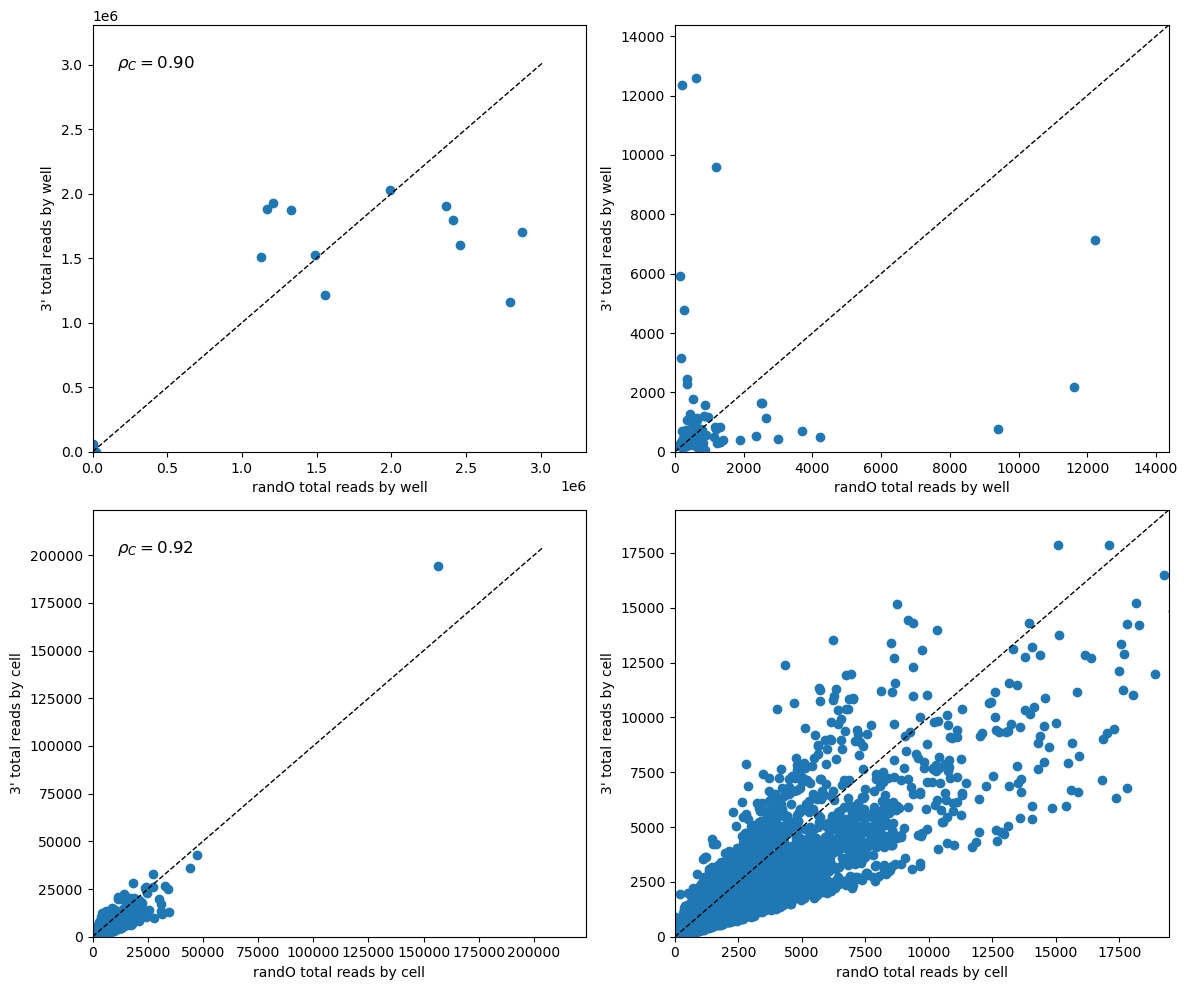

In [97]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

polyT_well_reads = wells_data.obs[wells_data.obs['polyT']].groupby('well')['n_counts'].sum()
randO_well_reads = wells_data.obs[wells_data.obs['randO']].groupby('well')['n_counts'].sum()
well_reads_df = pd.concat([polyT_well_reads, randO_well_reads], axis=1).fillna(0)
well_reads_df = well_reads_df.set_axis(['polyT_reads', 'randO_reads'], axis=1)

def plotByCell(ax, xlim = 1.15, ylim = 1.15, corr = True):
    ax.scatter(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
    ax.set_xlabel('randO total reads by well')
    ax.set_ylabel('3\' total reads by well')
    max_lim = max(well_reads_df['randO_reads'].max(), well_reads_df['polyT_reads'].max())
    ax.set_xlim(0, xlim*max_lim)
    ax.set_ylim(0, ylim*max_lim)
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(well_reads_df['randO_reads'], well_reads_df['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

def plotByWell(ax, xlim = 1.15, ylim = 1.15, corr = True):
    ax.scatter(parse_data.obs['randO_reads'], parse_data.obs['polyT_reads'])
    ax.set_xlabel('randO total reads by cell')
    ax.set_ylabel('3\' total reads by cell')
    max_lim = max(parse_data.obs['randO_reads'].max(), parse_data.obs['polyT_reads'].max())
    ax.set_xlim(0, xlim*max_lim)
    ax.set_ylim(0, ylim*max_lim)
    ax.plot([0, 1.05*max_lim], [0, 1.05*max_lim], color='black', linestyle='--', linewidth=1) # x=y line
    if corr:
        CCC_r = CCC(parse_data.obs['randO_reads'], parse_data.obs['polyT_reads'])
        ax.text(0.05, 0.9, r'$\rho_C=%.2f$' % (CCC_r, ), transform=ax.transAxes, fontsize=12) 

plotByCell(ax[0,0])
plotByCell(ax[0,1], 0.005, 0.005, False)
plotByWell(ax[1,0])
plotByWell(ax[1,1], 0.1, 0.1, corr = False)

plt.tight_layout()
plt.show()

# Parse Read Analysis

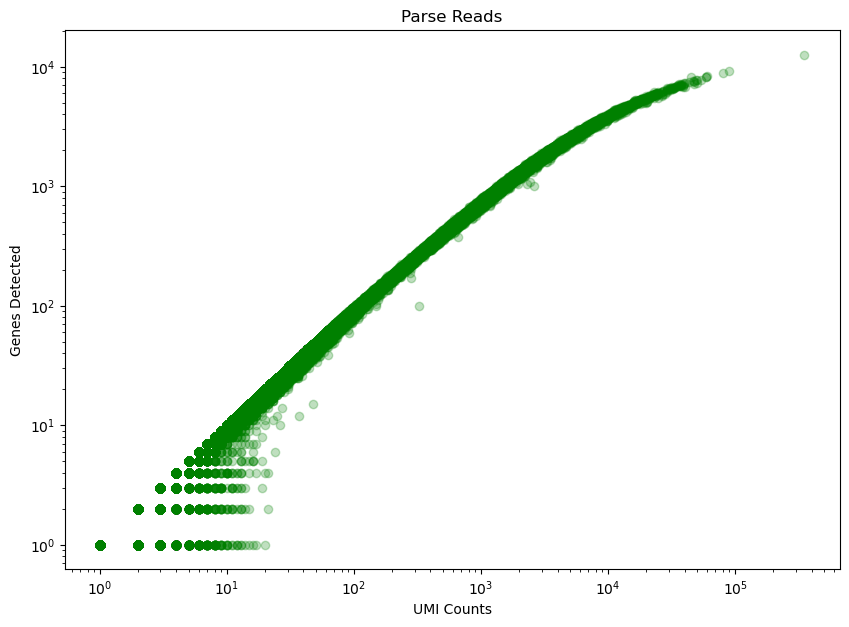

In [46]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(parse_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(parse_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("Parse Reads")

plt.show()

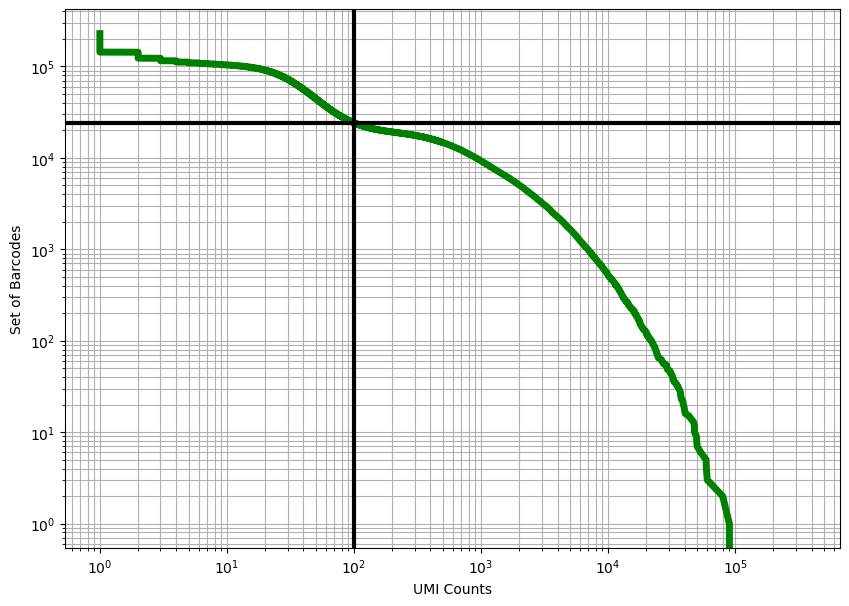

In [50]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 100  #@param {type:"integer"}
knee = np.sort((np.array(parse_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [51]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

24,138 cells passed the 100 UMI threshold


In [52]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [53]:
lncRNA_genes = set(parse_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [54]:
# Identify lncRNA genes
parse_data.var["is_lnc"] = np.full(len(parse_data.var_names), False)
parse_data.var.loc[parse_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
parse_data.var["is_mito"] = parse_data.var_names.str.startswith("Mt")
# ribosomal genes
parse_data.var["is_ribo"] = parse_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = parse_data[:, parse_data.var['is_mito']].X.sum(axis=1)
ribo_counts = parse_data[:, parse_data.var['is_ribo']].X.sum(axis=1)
nc_counts = parse_data[:, parse_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = parse_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
parse_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
parse_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
parse_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

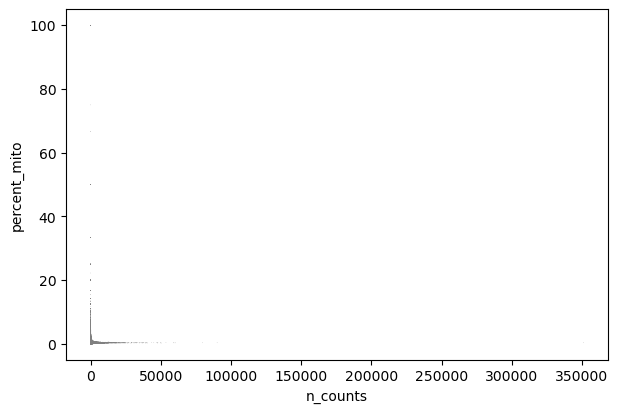

In [55]:
sc.pl.scatter(parse_data, x='n_counts', y='percent_mito')

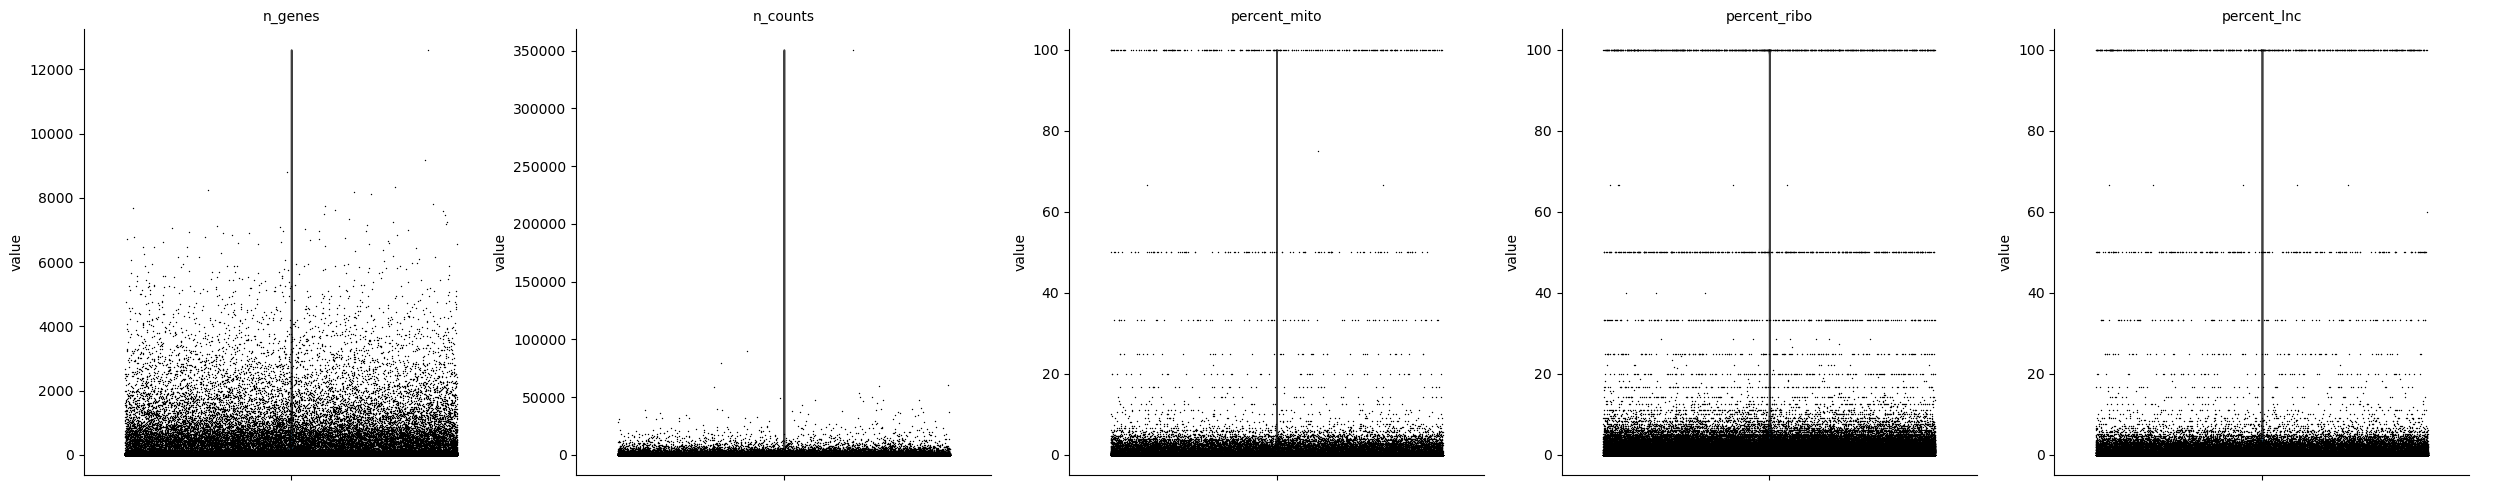

In [58]:
sc.pl.violin(parse_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [59]:
# Find top 10 genes by number of cells they are expressed in
genes = parse_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(parse_data[:,gene].X.toarray().transpose()[0] / np.array(parse_data.obs['n_counts'].tolist()) * 100))

In [60]:
# Add percent of counts for each gene to metadata
parse_data.var['percent_counts'] = parse_data.X.sum(axis=0).A1 / parse_data.X.sum() * 100

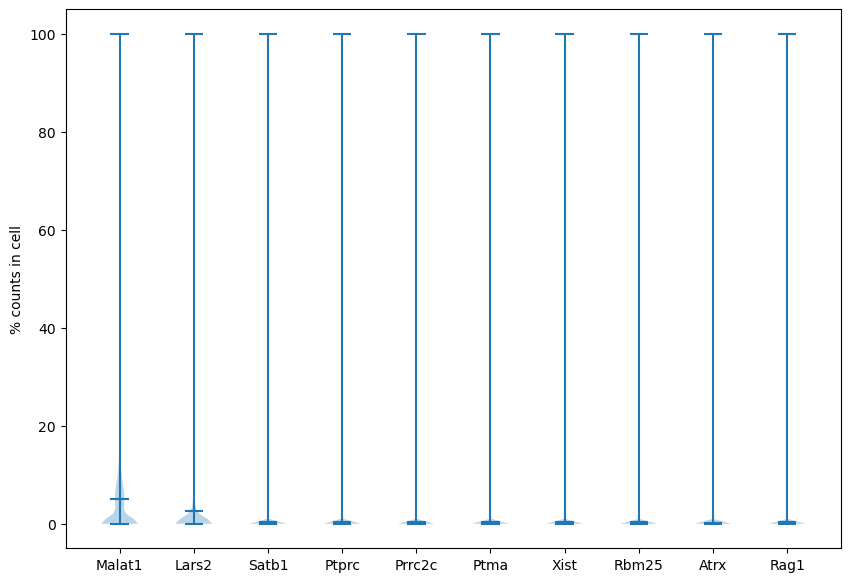

In [61]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [62]:
# Save the processed data
parse_data.obs.fillna(0, inplace=True)
parse_data.var.fillna(0, inplace=True)
parse_data.write('processed_parse.h5ad', compression="gzip")

# Parse PolyT Read Analysis

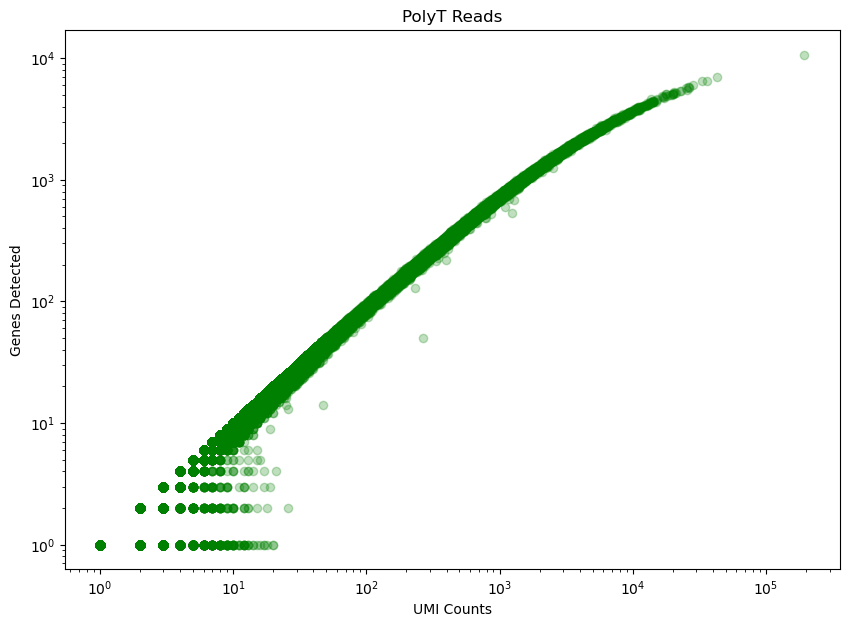

In [63]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(polyT_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(polyT_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

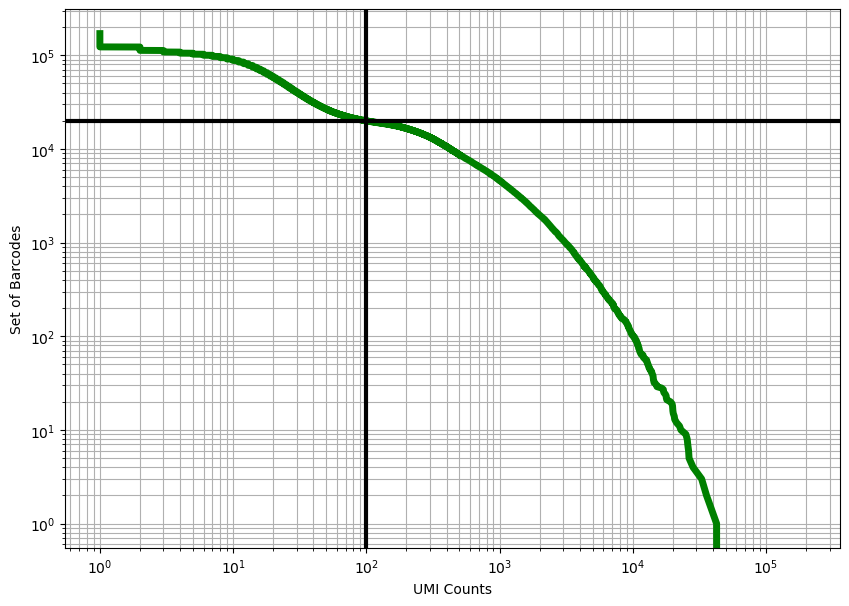

In [65]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 100  #@param {type:"integer"}
knee = np.sort((np.array(polyT_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [66]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

19,945 cells passed the 100 UMI threshold


In [67]:
lncRNA_genes = set(polyT_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [68]:
# Identify lncRNA genes
polyT_data.var["is_lnc"] = np.full(len(polyT_data.var_names), False)
polyT_data.var.loc[polyT_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
polyT_data.var["is_mito"] = polyT_data.var_names.str.startswith("Mt")
# ribosomal genes
polyT_data.var["is_ribo"] = polyT_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = polyT_data[:, polyT_data.var['is_mito']].X.sum(axis=1)
ribo_counts = polyT_data[:, polyT_data.var['is_ribo']].X.sum(axis=1)
nc_counts = polyT_data[:, polyT_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = polyT_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
polyT_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
polyT_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
polyT_data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

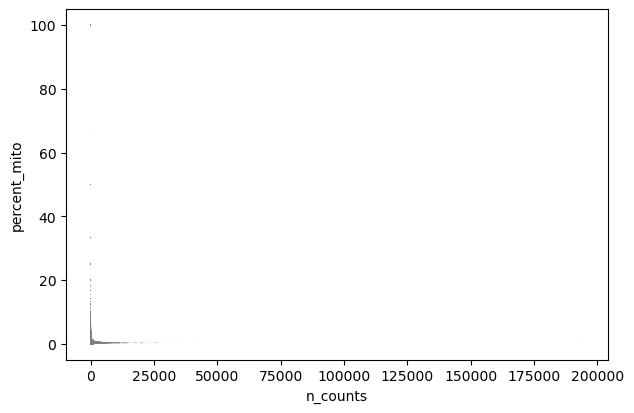

In [69]:
sc.pl.scatter(polyT_data, x='n_counts', y='percent_mito')

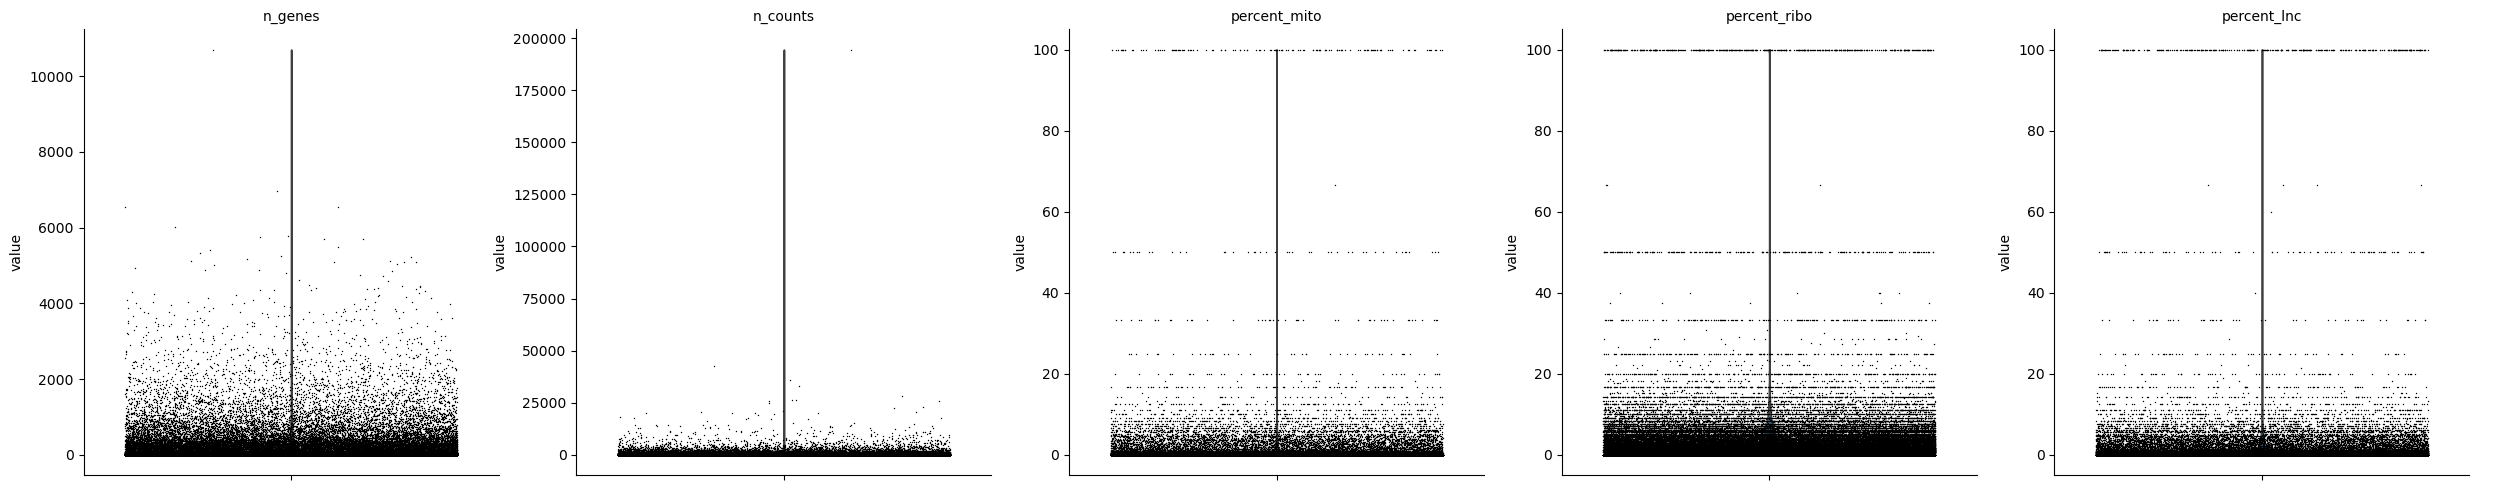

In [70]:
sc.pl.violin(polyT_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [71]:
# Find top 10 genes by number of cells they are expressed in
genes = polyT_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(polyT_data[:,gene].X.toarray().transpose()[0] / np.array(polyT_data.obs['n_counts'].tolist()) * 100))

In [72]:
# Add percent of counts for each gene to metadata
polyT_data.var['percent_counts'] = polyT_data.X.sum(axis=0).A1 / polyT_data.X.sum() * 100

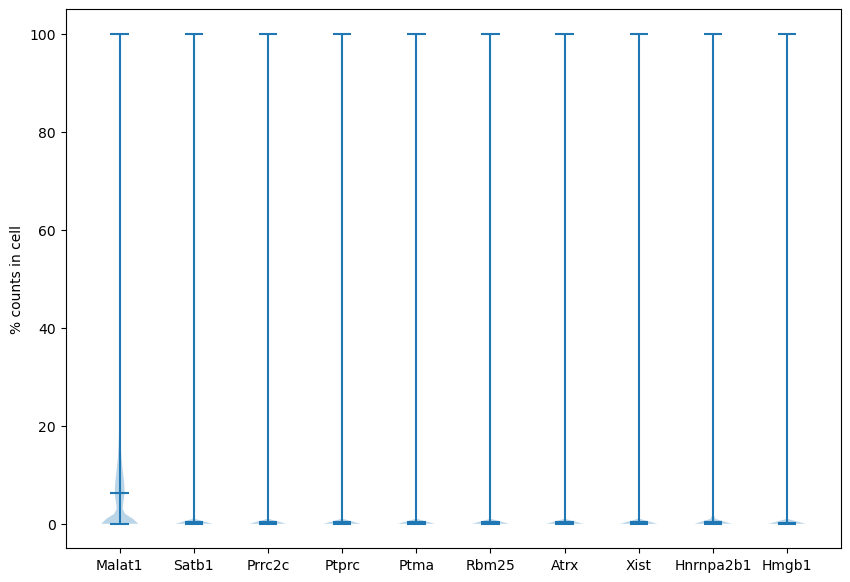

In [73]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [74]:
# Save processed data
polyT_data.obs.fillna(0, inplace=True)
polyT_data.var.fillna(0, inplace=True)
polyT_data.write('processed_polyT.h5ad', compression="gzip")

# Parse RandO Read Analysis

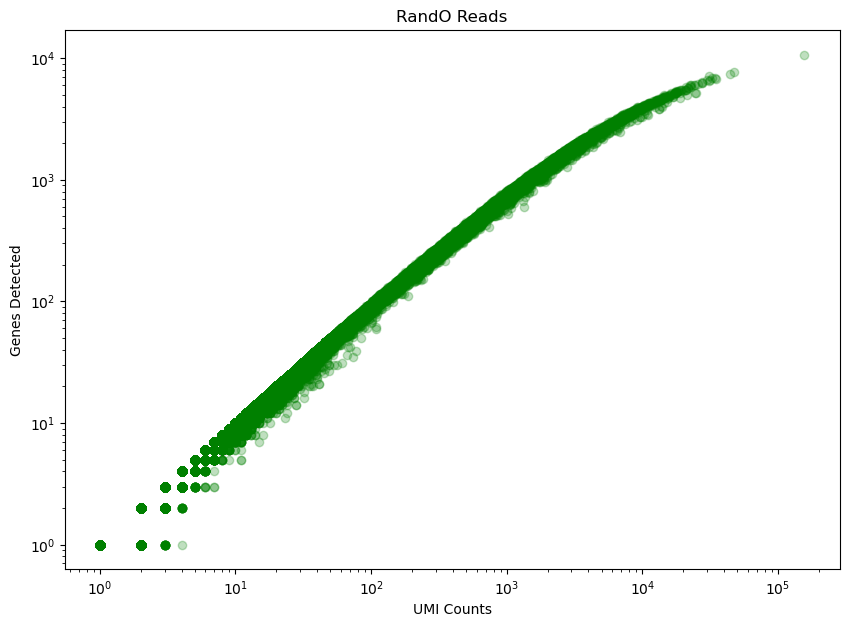

In [75]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(randO_data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(randO_data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("RandO Reads")

plt.show()

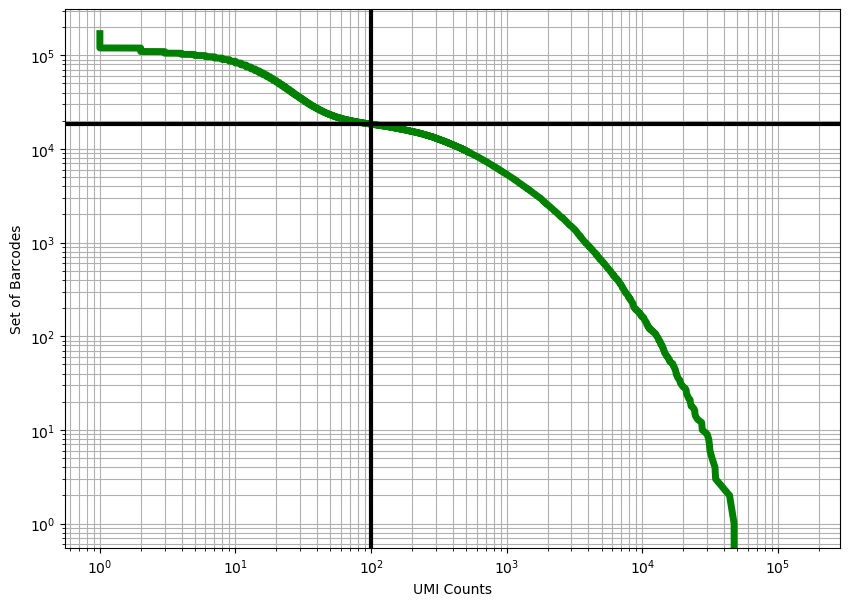

In [77]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 100  #@param {type:"integer"}
knee = np.sort((np.array(randO_data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [78]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

18,359 cells passed the 100 UMI threshold


In [79]:
lncRNA_genes = set(randO_data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [80]:
# Identify lncRNA genes
randO_data.var["is_lnc"] = np.full(len(randO_data.var_names), False)
randO_data.var.loc[randO_data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
randO_data.var["is_mito"] = randO_data.var_names.str.startswith("Mt")
# ribosomal genes
randO_data.var["is_ribo"] = randO_data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = randO_data[:, randO_data.var['is_mito']].X.sum(axis=1)
ribo_counts = randO_data[:, randO_data.var['is_ribo']].X.sum(axis=1)
lnc_counts = randO_data[:, randO_data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = randO_data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
randO_data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
randO_data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
randO_data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

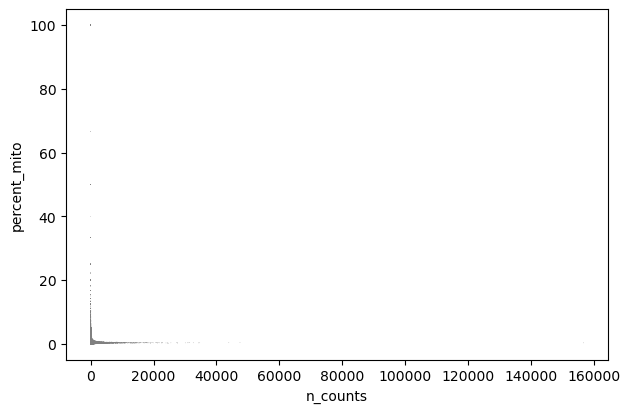

In [81]:
sc.pl.scatter(randO_data, x='n_counts', y='percent_mito')

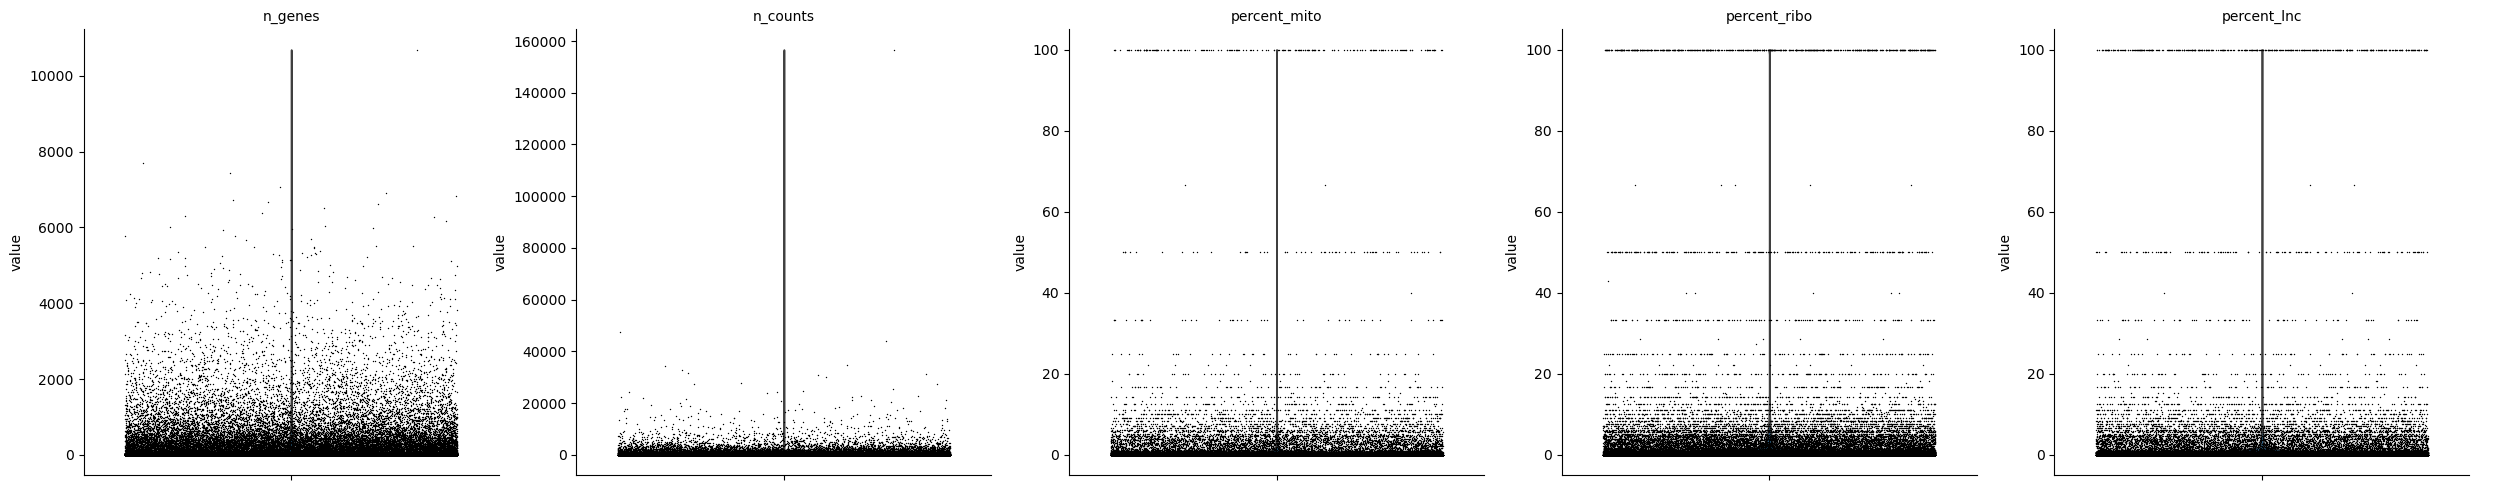

In [82]:
sc.pl.violin(randO_data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)

In [83]:
# Find top 10 genes by number of cells they are expressed in
genes = randO_data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(randO_data[:,gene].X.toarray().transpose()[0] / np.array(randO_data.obs['n_counts'].tolist()) * 100))

In [84]:
# Add percent of counts for each gene to metadata
randO_data.var['percent_counts'] = randO_data.X.sum(axis=0).A1  / randO_data.X.sum() * 100

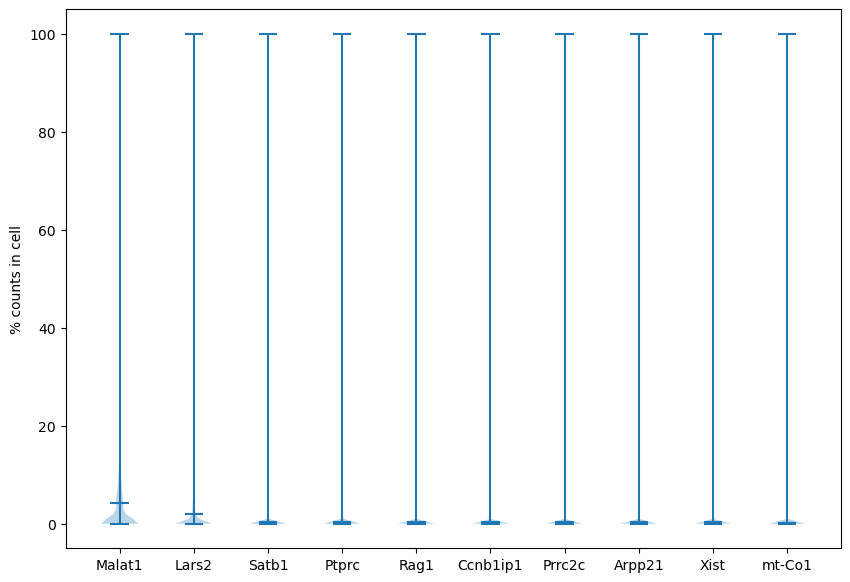

In [98]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [86]:
# Save processed data
randO_data.obs.fillna(0, inplace=True)
randO_data.var.fillna(0, inplace=True)
randO_data.write('processed_randO.h5ad', compression="gzip")